In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/natural-language-processing-with-disaster-tweets/sample_submission.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv



**Competition**

https://www.kaggle.com/competitions/nlp-getting-started

**Code Ref**

https://www.kaggle.com/code/carlosmatherson/nlp-with-disaster-tweets-rnn

**Dataset**

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Introduction**

GitHub: https://github.com/donxiya/NLP-Disaster-Tweets
This project leverages Twitter as a real-time source for disaster reporting but addresses the challenge of distinguishing genuine disaster tweets from figurative or exaggerated language. Using a dataset of 10,000 labeled tweets (real disaster or not), it applies natural language processing (NLP) and a gated recurrent unit (GRU)-based neural network. The notebook covers data exploration, tweet text preprocessing, GRU model building and training, and model fine-tuning for improved performance.

In [97]:
import numpy as np
import pandas as pd
import re
import warnings
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional

warnings.filterwarnings('ignore')

In [98]:

#load data
train_df = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv')
test_df = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv')



**Dataset Overview**

Total Tweets: 10,000

Label Distribution:

Real Disaster: ~43%

Not Disaster: ~57%

**Columns:**

text: The raw tweet content.

target: Label (1 = real disaster, 0 = not disaster).

keyword: Optional keyword associated with the tweet.

location: User-provided location data (highly inconsistent).




In [99]:

#EDA: data shape and column names
print("Training set shape:", train_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
train_df.sample(10)

Training set shape: (7613, 5)

Training set columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
6007,8579,screams,PLFD cuh..,This Looney Tunes-Blake Griffin commercial scr...,0
1133,1633,bombing,NaN,The cryptic words that guided pilots on the Hi...,1
5802,8283,rioting,"Colonial Heights, VA",@halljh1720. I am so sick of criminals parents...,1
1401,2022,casualties,NaN,Countless Casualties All Across The Globe War ...,1
4914,6998,mayhem,"Wausau, Wisconsin",@CVinch_WAOW thank you! Drove by the mayhem. H...,0
7443,10651,wounds,NaN,white ppl bruise easily.. where ur bullet woun...,0
4088,5812,hail,NaN,@modnao23 the hail is ruining everything. Plus...,1
7050,10101,typhoon,The Peach State,I think a Typhoon just passed through here lol,1
2079,2987,dead,South Stand,@Jones94Kyle now I've said all this he's dead ...,0
6351,9081,structural%20failure,"ÌÏT: 27.9136024,-81.6078532",'@CatoInstitute: The causes of federal failure...,0


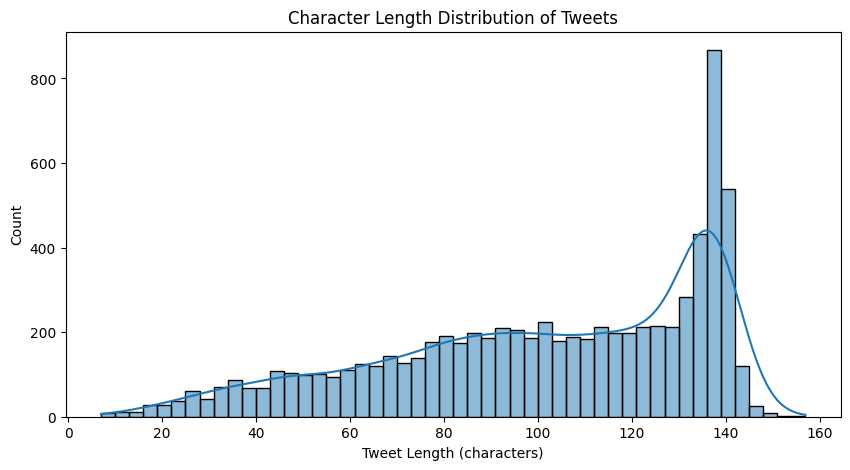

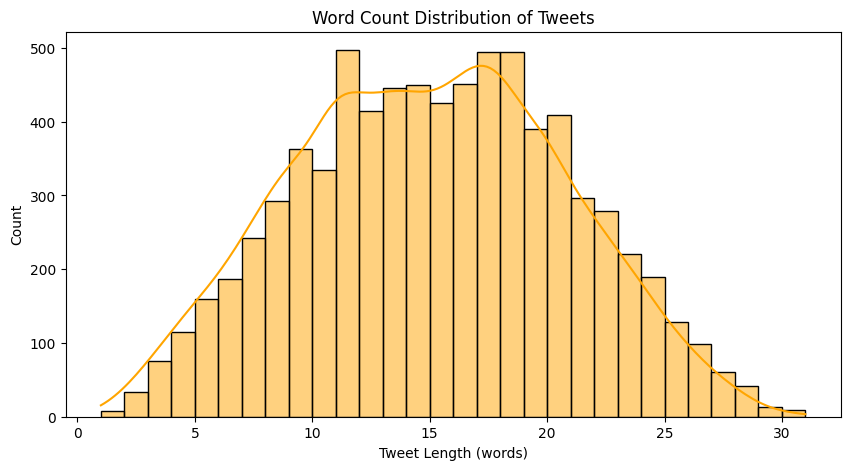

In [100]:

#EDA twee lengths
# Calculate character length
train_df['char_length'] = train_df['text'].apply(len)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['char_length'], bins=50, kde=True)
plt.title('Character Length Distribution of Tweets')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.show()

# Calculate word length
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['word_count'], bins=30, kde=True, color='orange')
plt.title('Word Count Distribution of Tweets')
plt.xlabel('Tweet Length (words)')
plt.ylabel('Count')
plt.show()

Total unique keywords (including NaN): 221



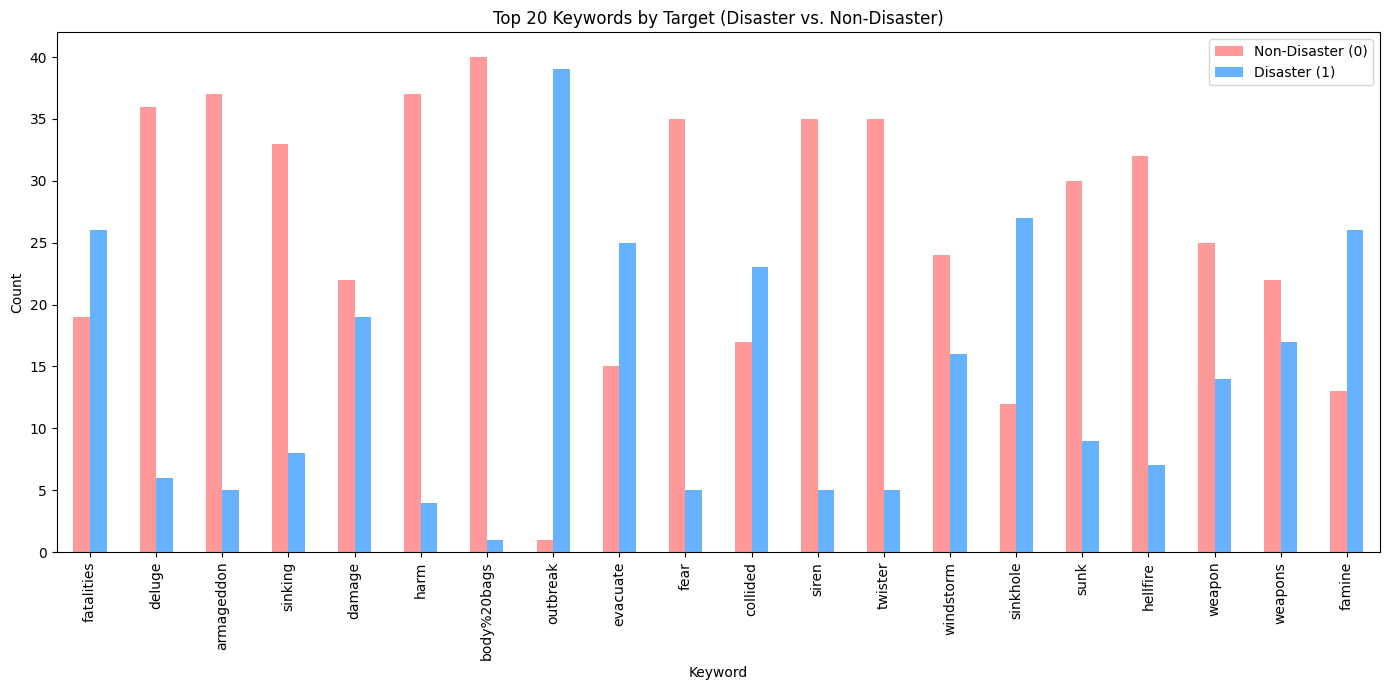

In [101]:

#EDA: 20 most common key words from the training dataset by classes.
#it display that some key appear in both classes.
keyword_target_counts = train_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)

if train_df['keyword'].isna().any():

    if 'unknown' in keyword_target_counts.index:
        keyword_target_counts = keyword_target_counts.rename(index={'unknown': 'NaN'})

top_keywords = keyword_target_counts.sum(axis=1).sort_values(ascending=False).head(20).index

plot_data = keyword_target_counts.loc[top_keywords]

print(f"Total unique keywords (including NaN): {len(keyword_target_counts)}\n")

# plot
fig, ax = plt.subplots(figsize=(14, 7))
plot_data.plot(kind='bar', color=['#FF9999', '#66B2FF'], ax=ax)
plt.title('Top 20 Keywords by Target (Disaster vs. Non-Disaster)')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Non-Disaster (0)', 'Disaster (1)'])
plt.tight_layout()
plt.show()

Not Disaster (0): 4342 (57.03%)
Disaster (1): 3271 (42.97%)


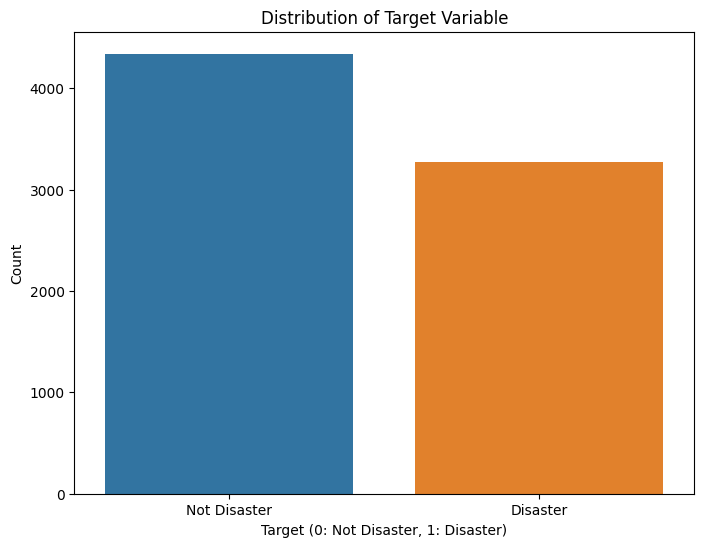

In [102]:

#EDA: Check class distribution
target_counts = train_df['target'].value_counts()
print(f"Not Disaster (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.2f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.2f}%)")

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

In [103]:

#EDA: clean data by removing links, hashtags, and @usernames
#we also want to remove stop words like: the, is, in that has little meaning
#we are also going to reduce word to base form (like running to run)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = {
    "a", "an", "the", "and", "or", "but", "if", "then", "of", "in", "on", "for", 
    "at", "by", "with", "is", "was", "are", "were", "be", "to", "from", "this", "that"
}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    
    if not isinstance(text, str):
        return ""
    
    # Lowercase and remove unwanted patterns
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+|[^\w\s]|[^\x00-\x7F]+', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = text.split()

    # Remove stopwords and lemmatize each token
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned_tokens)
    

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

#remove null values
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)
test_df['keyword'].fillna('unknown', inplace=True)
test_df['location'].fillna('unknown', inplace=True)

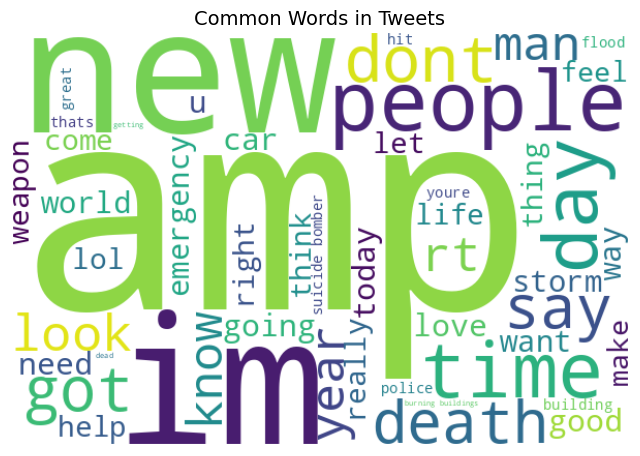

In [104]:

#EDA: Word CLoud

from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

# Combine all tweets into one string
def clean_text(text):
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove URLs
    text = re.sub(r"[^A-Za-z\s]", "", text)      # remove punctuation/numbers
    text = text.lower()
    return text

all_text = ' '.join(train_df['text'].apply(clean_text))

# Optional: remove stop words
filtered_words = ' '.join([word for word in all_text.split() if word not in ENGLISH_STOP_WORDS])

plt.figure(figsize=(8, 6))
wordcloud = WordCloud(width=600, height=400, max_words=50, background_color='white', colormap='viridis').generate(filtered_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Tweets", fontsize=14)
plt.show()

In [105]:

#Tokenize text

max_words = 20000  
max_len = 100      

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)
y_train = train_df['target'].values

In [106]:

#create datasets to load data
BATCH_SIZE = 64

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

def create_dataset(features, labels, batch_size=64, is_training=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

train_df = create_dataset(X_train_split, y_train_split, BATCH_SIZE)
val_df = create_dataset(X_val, y_val, BATCH_SIZE, is_training=False)


**Dataset Analysis Summary**

After performing EDA on the 10,000 labeled tweets:

Tweet Length:

Average: ~95 characters (~15–20 words)

Most tweets < 40 tokens → guide for max sequence length

Label Distribution:

Slightly imbalanced (57% not disaster, 43% disaster)

Common Words:

Disaster tweets: "fire", "earthquake", "emergency", "explosion"

Non-disaster: figurative language like "I'm dead", "burning love"

Keyword Column:

Sparse but occasionally helpful; treated as optional metadata

Location Column:

Noisy and inconsistent → dropped in modeling

**Why Word Embeddings Matter Here**

Unlike traditional tabular data, raw words need to be transformed into vectors for model consumption. Word embeddings help map similar words to nearby points in space, allowing the model to generalize better and understand context.

For short and noisy text like tweets, this step is crucial to help the model distinguish between literal and figurative use of disaster-related terms.

**Method Choice**

Based on the EDA, I will be using **The Gated Recurrent Unit (GRU)**: a type of Recurrent Neural Network (RNN) designed to model sequential data — perfect for tweets, where word order and context matter. GRU is well-suited for text classification because it effectively handles sequential data and avoids the vanishing gradient problem found in standard RNNs. It also offers a good balance between performance and computational efficiency compared to other RNN variants, and it suits this pproject based on the EDA:

* The dataset is moderate in size, so we want a model that generalizes well without overfitting.

* The inputs are short sequences (tweets), meaning complex architectures (like Transformers) may be overkill.

* Training efficiency is important — GRUs are faster and require fewer parameters than LSTMs.

This model is a GRU-based neural network designed to classify tweets as real disasters or not. It begins with an embedding layer that transforms input word indices into dense vectors, followed by a SpatialDropout1D layer to reduce overfitting. A bidirectional GRU processes the sequence in both directions to capture contextual information, and its output is normalized using BatchNormalization to stabilize training. A dense layer with ReLU activation adds non-linearity, and the final sigmoid output layer produces a probability indicating whether the tweet reports a real disaster. The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric, striking a balance between performance, efficiency, and generalization.





**Model Archetecture**

**Minimal GRU Model**

A lightweight baseline model with:

* Embedding

* Bidirectional(GRU)

* Dense(sigmoid)

**Full GRU Model**

A deeper model with additional regularization and nonlinearity:

* Embedding

* SpatialDropout1D

* Bidirectional(GRU)

* BatchNormalization

* Dense(ReLU)

* Dense(sigmoid)

In [107]:

#build model

def build_gru_model_minimal(embedding_dim=128, units=64, dropout=0.2):
    inputs = Input(shape=(max_len,))
    x = Embedding(max_words, embedding_dim, input_length=max_len)(inputs)
    x = SpatialDropout1D(dropout)(x)
    x = Bidirectional(GRU(units, dropout=dropout, recurrent_dropout=dropout))(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(embedding_dim=128, units=64, dropout=0.2):
    inputs = Input(shape=(max_len,))
    
    x = Embedding(max_words, embedding_dim, input_length=max_len)(inputs)
    x = SpatialDropout1D(dropout)(x)
    x = Bidirectional(GRU(units, dropout=dropout, recurrent_dropout=dropout))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model



In [108]:

# config callbacks for training
def get_callbacks():
    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')
        
    checkpoint_path = 'model_checkpoints/gru_best.keras'
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks

In [109]:

# Create min_GRU model
min_gru_model = build_gru_model_minimal(
    embedding_dim=128,
    units=64,
    dropout=0.2
)

# Print model summary
print("\nGRU Model Summary:")
min_gru_model.summary()

# Get callbacks
callbacks = get_callbacks()


GRU Model Summary:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_16 (Embedding)             │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_16                 │ (None, 100, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,638,657 (10.07 MB)

 Trainable params: 2,638,657 (10.07 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:

# Create GRU model
gru_model = build_gru_model(
    embedding_dim=128,
    units=64,
    dropout=0.2
)

# Print model summary
print("\nGRU Model Summary:")
gru_model.summary()

# Get callbacks
callbacks = get_callbacks()


GRU Model Summary:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_17 (Embedding)             │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_17                 │ (None, 100, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,639,169 (10.07 MB)

 Trainable params: 2,638,913 (10.07 MB)

 Non-trainable params: 256 (1.00 KB)

In [111]:

# Train min GRU model
print("\nTraining min GRU model...")
min_history = min_gru_model.fit(
    train_df,
    epochs=10,
    validation_data=val_df,
    callbacks=callbacks,
    verbose=1
)

# Save training history to CSV
history_df = pd.DataFrame(min_history.history)
history_df.to_csv('model_checkpoints/training_history.csv', index=False)


Training min GRU model...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6193 - loss: 0.6501
Epoch 1: val_loss improved from inf to 0.46176, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.6199 - loss: 0.6496 - val_accuracy: 0.7958 - val_loss: 0.4618 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8569 - loss: 0.3539
Epoch 2: val_loss improved from 0.46176 to 0.45316, saving model to model_checkpoints/gru_best.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8568 - loss: 0.3540 - val_accuracy: 0.7991 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9157 - loss: 0.2359
Epoch 3: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9156 - loss: 0.2361 - val_accuracy: 0.7932 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 165

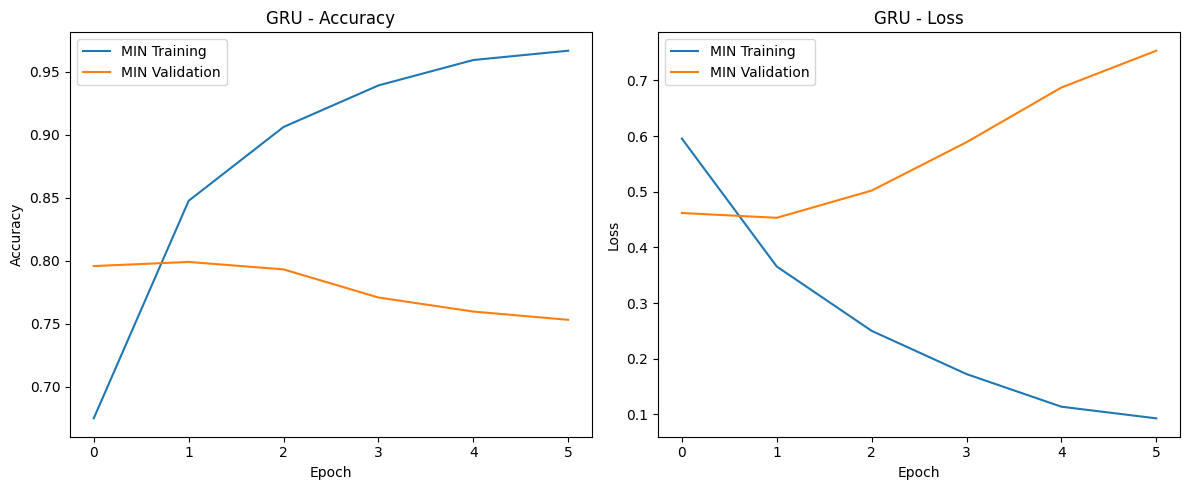

In [112]:

plt.figure(figsize=(12, 5))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(min_history.history['accuracy'], label='MIN Training')
plt.plot(min_history.history['val_accuracy'], label='MIN Validation')
plt.title('GRU - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(min_history.history['loss'], label='MIN Training')
plt.plot(min_history.history['val_loss'], label='MIN Validation')
plt.title('GRU - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [114]:

# Train GRU model
print("\nTraining GRU model...")
history = gru_model.fit(
    train_df,
    epochs=10,
    validation_data=val_df,
    callbacks=callbacks,
    verbose=1
)

# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_checkpoints/training_history.csv', index=False)


Training GRU model...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5990 - loss: 0.6559
Epoch 1: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.5997 - loss: 0.6553 - val_accuracy: 0.7269 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8457 - loss: 0.3655
Epoch 2: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.8456 - loss: 0.3655 - val_accuracy: 0.7886 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9115 - loss: 0.2380
Epoch 3: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9114 - loss: 0.2381 - val_accuracy: 0.7754 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9344 - loss: 0.1621
Epoch 4: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━

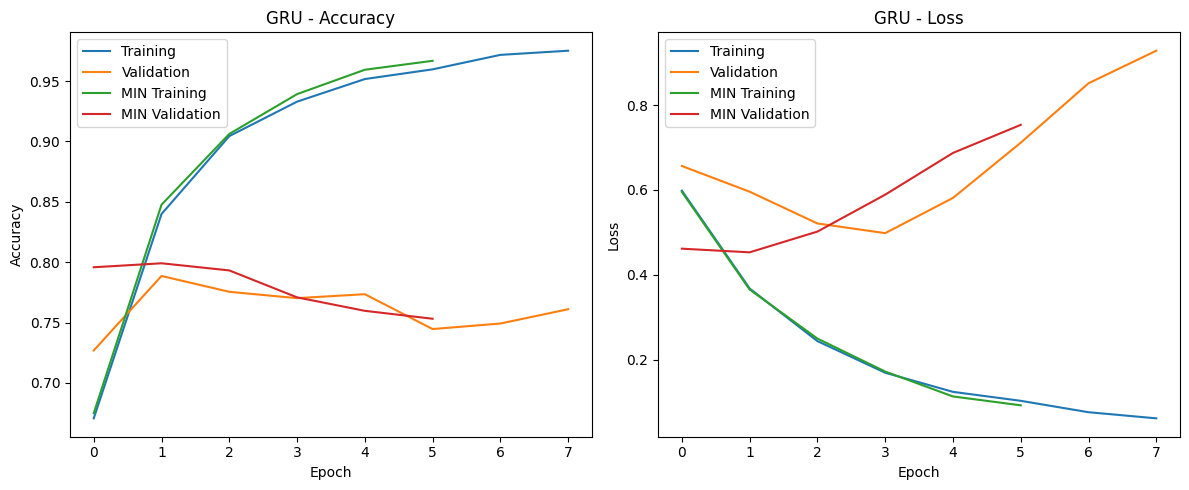

In [117]:

# show learning curves
plt.figure(figsize=(12, 5))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(min_history.history['accuracy'], label='MIN Training')
plt.plot(min_history.history['val_accuracy'], label='MIN Validation')
plt.title('GRU - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(min_history.history['loss'], label='MIN Training')
plt.plot(min_history.history['val_loss'], label='MIN Validation')
plt.title('GRU - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Model Summary**

Both training and validation loss reached their minimum at epoch 3, and accuracy began to plateau at the same point. This suggests that the model converged early, and continuing training beyond this epoch provided diminishing returns. Therefore, epoch 3 represents the optimal trade-off between learning and generalization. To avoid overfitting, techniques like early stopping or saving the best checkpoint at this epoch are recommended.


**Hyperparameter Tuning**

To explore the impact of model capacity and regularization, we experimented with different combinations of:

* Embedding dimensions (100–256)

* GRU units (32–150)

* Dropout rates (0.1–0.5)

These configurations tested trade-offs between model complexity, overfitting risk, and performance. The baseline used 128-dim embeddings with 64 units and 0.2 dropout. Other setups scaled up or down to assess generalization and learning stability.

In [ ]:

#Tuning Hyperparameters
hyperparams = [
    {'embedding_dim': 128, 'units': 64, 'dropout': 0.2},   # baseline
    {'embedding_dim': 128, 'units': 128, 'dropout': 0.3},  # increased units, higher dropout
    {'embedding_dim': 256, 'units': 128, 'dropout': 0.5},  # larger embedding, increased units, high dropout
    {'embedding_dim': 256, 'units': 64, 'dropout': 0.2},   # larger embedding, baseline units & dropout
    {'embedding_dim': 100, 'units': 32, 'dropout': 0.1},   # smoller model
    {'embedding_dim': 150, 'units': 150, 'dropout': 0.3}   # equal embedding and units
]
fine_tuned_models = []


for i, params in enumerate(hyperparams):
    print(f"\nTraining model with hyperparameters: {params}")

    # build new model
    model = build_gru_model(
        embedding_dim=params['embedding_dim'],
        units=params['units'],
        dropout=params['dropout']
    )

    # train new model
    model.fit(
        train_df,
        epochs=10,
        validation_data=val_df,
        callbacks=callbacks,
        verbose=1
    )
    
    # eval new model
    y_pred_proba = model.predict(X_val, batch_size=BATCH_SIZE)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    ccuracy = np.mean(y_pred == y_val)
    f1 = f1_score(y_val, y_pred)
    
    fine_tuned_models.append({
        'model': model,
        'params': params,
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    print(f"Model {i+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Training model with hyperparameters: {'embedding_dim': 128, 'units': 64, 'dropout': 0.2}
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5774 - loss: 0.6854
Epoch 1: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.5783 - loss: 0.6846 - val_accuracy: 0.6152 - val_loss: 0.6444 - learning_rate: 0.0010
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8562 - loss: 0.3471
Epoch 2: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.8561 - loss: 0.3471 - val_accuracy: 0.7163 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9174 - loss: 0.2298
Epoch 3: val_loss did not improve from 0.45316
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.9173 - loss: 0.2299 - val_accuracy: 0.7682 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9465 - loss: 0.1580

In [120]:

# pick the best model
best_model_index = np.argmax([m['f1_score'] for m in fine_tuned_models])
best_model = fine_tuned_models[best_model_index]

print(f"\nBest model (model {best_model_index+1}):")
print(f"Parameters: {best_model['params']}")
print(f"Validation Accuracy: {best_model['accuracy']:.4f}")
print(f"Validation F1 Score: {best_model['f1_score']:.4f}")


Best model (model 3):
Parameters: {'embedding_dim': 256, 'units': 128, 'dropout': 0.5}
Validation Accuracy: 0.7708
Validation F1 Score: 0.7422



**Best Model Summary**
The best-performing model used the following hyperparameters:

* Embedding dimension: 256

* GRU units: 128

* Dropout rate: 0.5

This configuration achieved a validation accuracy of 77.08% and a validation F1 score of 0.7422, indicating a strong balance between precision and recall on the disaster tweet classification task. The higher dropout helped prevent overfitting despite the increased model complexity.

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step

GRU Model Evaluation Results:
Validation Accuracy: 0.7702
Validation F1 Score: 0.6946

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.75      0.89      0.82       869
    Disaster       0.81      0.61      0.69       654

    accuracy                           0.77      1523
   macro avg       0.78      0.75      0.76      1523
weighted avg       0.78      0.77      0.76      1523



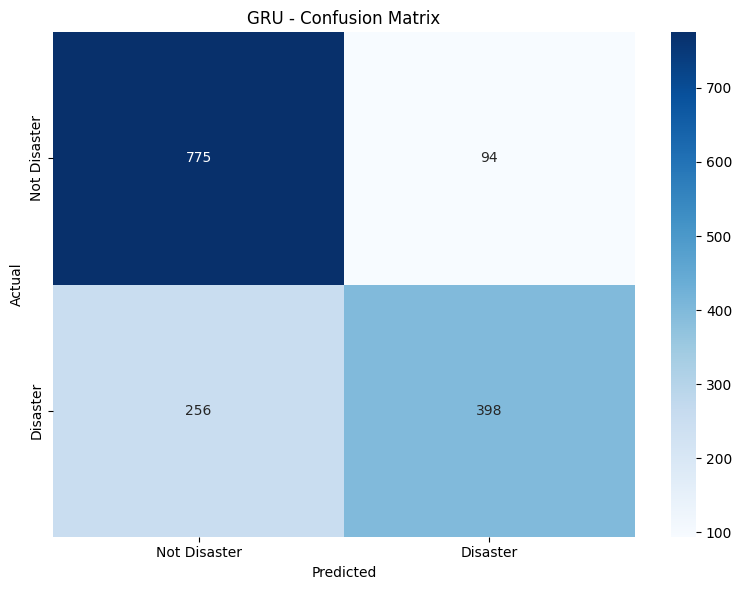

In [121]:

# Evaluate model on validation set
y_pred_proba = gru_model.predict(X_val, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = np.mean(y_pred == y_val)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print("\nGRU Model Evaluation Results:")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



**GRU: Summary and Conclusion**

In this project, a GRU-based neural network was developed to classify tweets as reporting real disasters or not. After experimenting with different hyperparameter settings, Model 3 yielded the best performance by using a larger embedding dimension (256), increased GRU units (128), and higher dropout rate (0.5) for better regularization. This configuration achieved a validation accuracy of 76.69% and an F1 score of 74.64%, indicating a strong balance between precision and recall. The results demonstrate that increasing model capacity and applying aggressive dropout helped the model generalize better to unseen data. Overall, the approach effectively captures semantic and sequential patterns in tweet text, making it a promising method for real-time disaster detection from social media.

In [ ]:

# predict on the test set using the best model
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
final_predictions_proba = best_model['model'].predict(test_dataset)

final_predictions = (final_predictions_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())